In [39]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.


In [40]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

In [41]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'wall_expungements', 'walls', 'walls_sets']


In [42]:
def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

In [43]:
# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

In [44]:
# this feels so wrong but wcyd. Could reduce the lines of code but lets just keep it easy to read and understand
def map_vgrade(difficulty):
    if 10 <= difficulty < 12:
        return 0
    elif 12 <= difficulty < 14:
        return 1
    elif 14 <= difficulty < 16:
        return 2
    elif 16 <= difficulty < 18:
        return 3
    elif 18 <= difficulty < 20:
        return 4
    elif 20 <= difficulty < 22:
        return 5
    elif 22 <= difficulty < 23:
        return 6
    elif 23 <= difficulty < 24:
        return 7
    elif 24 <= difficulty < 26:
        return 8
    elif 26 <= difficulty < 28:
        return 9
    elif 28 <= difficulty < 29:
        return 10
    elif 29 <= difficulty < 30:
        return 11
    elif 30 <= difficulty < 31:
        return 12
    elif 31 <= difficulty < 32:
        return 13
    elif 32 <= difficulty < 33:
        return 14
    elif difficulty >= 33:
        return 15
    else:
        return None


### Create DF with necessary columns and data

In [45]:
# print(globals()['ascents'].head().to_string(index=False))
climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
# climb_cache_fields = globals()['climb_cache_fields']
merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner') #.drop(columns=['frames'])
# Drop rows with layout_id not equal to 1
merged_df = merged_df[merged_df['layout_id'] == 1]

# remove rows with more than 1 ascensionist
merged_df = merged_df[merged_df['ascensionist_count'] >= 2]
merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
filtered_df = merged_df.loc[:, filtered_columns]

# print(merged_df_filtered.head().to_string(index=False))
# show(filtered_df)

# r12 - starthold  5
# r13 - hand hold  2
# r14 - finish hold 3
# r15 - foot hold   4
# p - hold position?

# p1454r15p1455r15p1457r15p1467r15p1469r15p1477r15p1485r15p1493r15p1511r15p1521r15p1532r15p1547r15p1549r15
# p1144r15 p1195r13 p1196r12 p1233r12 p1268r13 p1280r13 p1304r13 p1355r13 p1375r13 p1393r14 p1504r15 p1506r15 p1524r15 p1534r15 p1572r15 - EK | Crimp is not a crux

# p1085r15 p1124r12 p1176r12 p1196r13 p1244r13 p1283r13 p1332r13 p1383r14 p1385r14 p1504r15 p1514r15 - Pinch n' Gaston

# p1205r15 p1234r12 p1272r13 p1303r13 p1340r13 p1387r14 p1487r15 p1514r15 -sheep4wood

# p1165r12 p1271r13 p1286r13 p1333r14 p1469r15 p1476r15 - Fission

# p1146r12 p1163r12 p1227r13 p1249r13 p1265r13 p1269r14 p1457r15 p1467r15 p1484r15 p1496r15 p1503r15 p1506r15 p1516r15 - Plastic Age Mindset

# p1127r12 p1164r12 p1233r13 p1235r13 p1283r13 p1287r13 p1299r13 p1348r13 p1379r14 p1458r15 p1507r15 - anti-compressant

#layout_ids
# 1 - original board ( only meaningfulone)
# 2-8 ( other boards)


### Some Graphs

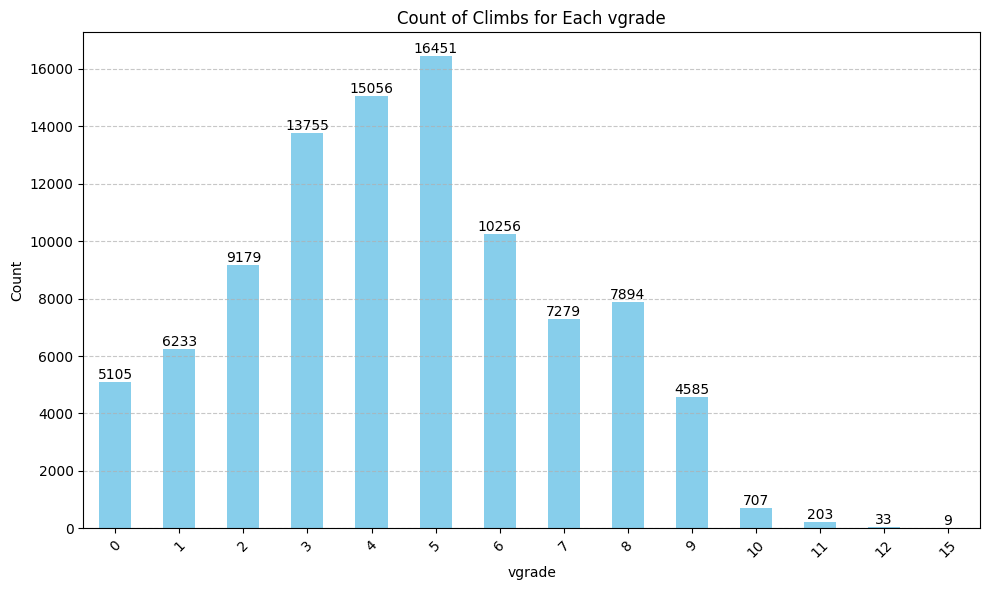

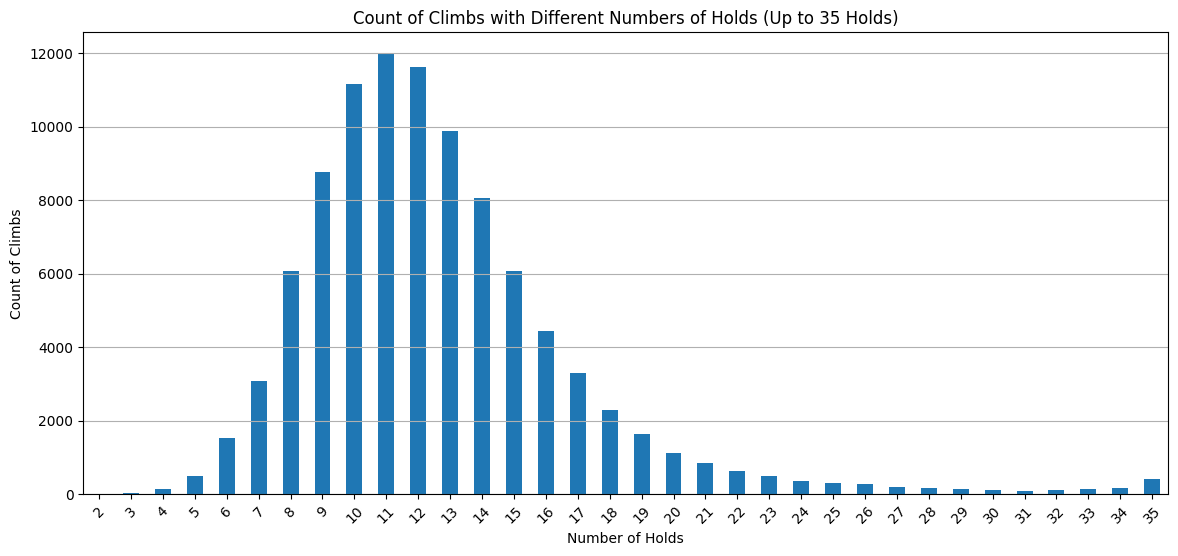

Average Number of Holds: 12.627361238245818


In [46]:
# Calculate vgrade counts
vgrade_counts = filtered_df['vgrade'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = vgrade_counts.plot(kind='bar', color='skyblue')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom')
plt.title('Count of Climbs for Each vgrade')
plt.xlabel('vgrade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Assuming 'filtered_df' contains your DataFrame with the 'frames' column
filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

# Filter out counts beyond 35 holds
filtered_counts = filtered_df['hold_count'].value_counts().sort_index().loc[:35]

# Plotting the count of climbs with a certain number of holds
plt.figure(figsize=(14, 6))  # Adjust the width by changing the first value (e.g., 14)
filtered_counts.plot(kind='bar')
plt.title('Count of Climbs with Different Numbers of Holds (Up to 35 Holds)')
plt.xlabel('Number of Holds')
plt.ylabel('Count of Climbs')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

total_hold_count = (filtered_counts.index * filtered_counts).sum()

# Calculate total count of climbs
total_climbs = filtered_counts.sum()

# Calculate average number of holds
average_holds = total_hold_count / total_climbs

print("Average Number of Holds:", average_holds)



### Preprocessing Data Functions

In [47]:
# the value is:
# 2-start 
# 3-hand 
# 4-finish
# 5-feet

def id_to_index(id):
    
    if id <=1089: #bottom large (row) 17x1
        index_offset = 35
        row_index = 16 - (id - 1074)
        final_index = index_offset + 2 * row_index
    elif id <= 1395: #big holds (matrix) 17x18
        index_offset = 35 + 35
        index = id-1089
        row = index//17
        row_index = index%17
        final_index = index_offset + row * 70 + 2 *row_index   
    elif id <=1464: #bottom small (row) 18x1
        row_index = 17 - (id - 1447)
        final_index = 2 * row_index + 1
    elif id <= 1599: # small holds (matrix) 9x15
        index_offset = 35 + 35 + 35 + 1
        index = id-1464
        row = index//9
        row_index = index% 9
        final_index = index_offset + row * 70 + 4 * (row_index-1)
    else:
        final_index = id
        print(id) 
    return final_index

def id_to_coordinate(id):
    index = id_to_index(id)-1
    x = index % 35
    y = index//35
    if y >=35:
        y-=2 #because the top 2 rows of large hand holds dont have any feet so its offset
    return (x,y)

def frame_to_ids(frame):
    ids_list_1 = []
    ids_list_2 = []
    
    # Split the frame string based on the 'p' delimiter
    filtered_frame = frame.replace(',', '').replace('"', '')
    frame_parts = filtered_frame.split('p')[1:]
    
    for entry in frame_parts: 
        parts = entry.split('r')
        id_1 = int(parts[0])
        id_2 = int(parts[1])
        
        ids_list_1.append(id_1)
        if id_2 in [12, 13, 14, 15]:
            id_2 = [2, 3, 4, 5][id_2 - 12]
        ids_list_2.append(id_2)
    return ids_list_1, ids_list_2

# takes in frame and converts to list of triplets with xy being coordiante in board matrix and z being the value
def frame_to_triplets(frame):
    ids_list_1, ids_list_2 = frame_to_ids(frame)
    
    triplet_list = []
    for id_1, id_2 in zip(ids_list_1, ids_list_2):
        coordinate = id_to_coordinate(id_1)
        triplet = (coordinate[0],coordinate[1], id_2)
        triplet_list.append(triplet)
    
    return triplet_list

# frame = "p1127r12p1164r12p1233r13p1235r13p1283r13p1287r13p1299r13p1348r13p1379r14p1458r15p1507r15"
# triplet_list = frame_to_triplets(frame)
# print("Triplet List:", triplet_list)

def triplets_to_matrix(triplet_list):
    # Initialize a 35x35 matrix with zeros
    matrix = [[0] * 35 for _ in range(35)]

    for triplet in triplet_list:
        x, y, z = triplet
        matrix[y][x] = z
    
    return matrix

def frame_to_sparse_matrix(frame):
    triplet_list = frame_to_triplets(frame)
    matrix = triplets_to_matrix(triplet_list)
    sparse_matrix = sp.coo_matrix(matrix)
    return sparse_matrix

def is_frame_valid(frame):
    # Extract the first list of IDs from the frame
    if "x" in frame:
        return False
    ids_list_1, _ = frame_to_ids(frame)
    
    # look if any value in the first list is greater than 2000
    for value in ids_list_1:
        if value > 2000:
            return False
    return True

### Graph Average Starting Hold Height

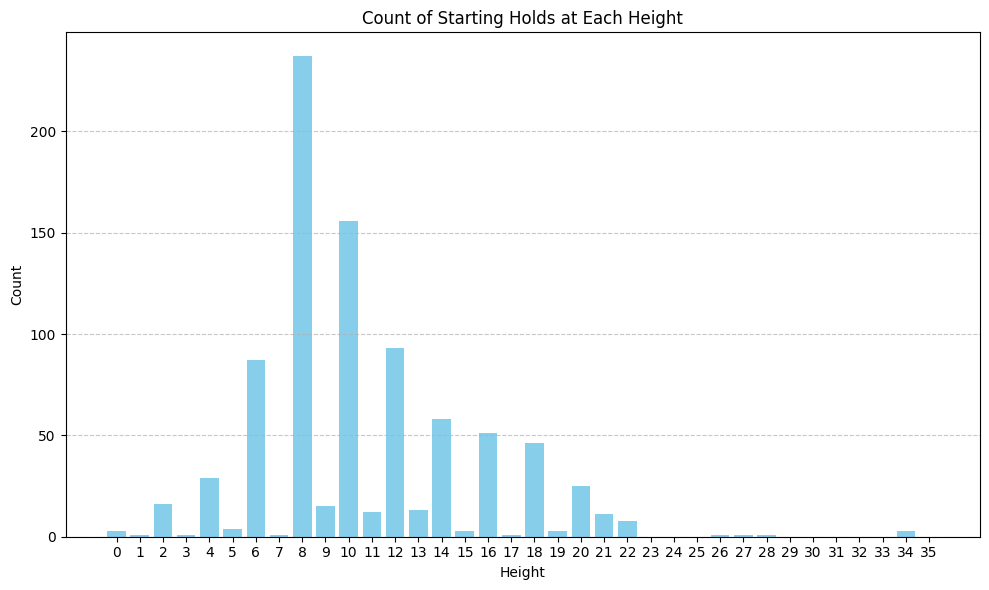

Overall Average Starting Hold Height: 10.652272727272727


In [48]:
# Initialize a list to store the count of starting holds at each height
starting_hold_height_counts = [0] * 36  # 36 heights from 0 to 35

# Initialize counter to track the number of climbs processed
climb_counter = 0
num_climbs = 500

# Initialize a variable to store the total heights of all starting holds
total_starting_hold_heights = 0

# Iterate through each climb in the DataFrame
for index, climb in filtered_df.iterrows():
    # Check if the number of processed climbs has reached the specified number of climbs
    if climb_counter >= num_climbs:
        break
    
    try:
        # Convert the frame to a sparse matrix
        sparse_matrix = frame_to_sparse_matrix(climb['frames'])
        
        # Extract the y-coordinate values of starting holds (marked as 2)
        starting_holds_y = sparse_matrix.row[sparse_matrix.data == 2]
        
        # Count occurrences of each y-coordinate value and update the starting_hold_height_counts list
        for y in starting_holds_y:
            starting_hold_height_counts[y] += 1
            # Add the height of the starting hold to the total
            total_starting_hold_heights += y
        
        # Increment climb counter
        climb_counter += 1
    except (IndexError, ValueError):
        pass  # Skip climb silently

# Plot the count of starting holds at each height
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(range(36), starting_hold_height_counts, color='skyblue')
plt.title('Count of Starting Holds at Each Height')
plt.xlabel('Height')
plt.ylabel('Count')
plt.xticks(range(36))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate the overall average starting hold height across all climbs
total_starting_holds = sum(starting_hold_height_counts)
average_starting_hold_height = total_starting_hold_heights / total_starting_holds

print("Overall Average Starting Hold Height:", average_starting_hold_height)


### Create Text File

In [49]:
vgrade = -1  # set it to -1 for all grades
angle = -1

if vgrade == -1:#all grades
    filtered_df = filtered_df.copy()
elif vgrade == 0:
    filtered_df = filtered_df[filtered_df['vgrade'].isin([0, 1])]
else:
    vgrade_range = [max(vgrade - 1, 0), min(vgrade + 1, 15)]
    print(vgrade_range )
    print((vgrade_range[0], vgrade_range[1]))
    filtered_df = filtered_df[filtered_df['vgrade'].between(vgrade_range[0], vgrade_range[1])]
    
# filter climbs angle  
if angle == -1:
    pass
else:
    filtered_df = filtered_df[filtered_df['angle_y'] == angle]

# filter the DataFrame using is_frame_valid function
valid_mask = filtered_df['frames'].apply(is_frame_valid)
filtered_df = filtered_df[valid_mask]

# Extract frames from the DataFrame and concatenate them with spaces
climb_frames = filtered_df['frames'].apply(lambda x: ' '.join(x.split('p')))
with open('climbs.txt', 'w') as file:
    for climb in climb_frames:
        file.write(climb + '\n')


### Markov Chain Model

In [50]:
from collections import defaultdict
import string
import random

class Markov():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text = self.remove_punctuations(self.get_text())
        self.model = self.model()

    def get_text(self):
        text = []
        for line in open(self.file_path):
            text.append(line)
        return ' '.join(text)
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('','', string.punctuation))
    
    def model(self):
        # split the input text into individual words seperated by spaces
        words = self.text.split(' ')
        markov_dict = defaultdict(list)
        # create list of all word pairs
        for current_word, next_word in zip(words[0:-1], words[1:]):
            markov_dict[current_word].append(next_word)
        markov_dict = dict(markov_dict)
        print('Successfully Trained')
        return markov_dict
    
def predict_words(chain, first_word, number_of_words):
    if first_word in list(chain.keys()):
        word1 = str(first_word)
        predictions = word1.capitalize()
        # Generate the second word from the value list. Set the new word as the first word. Repeat.
        for i in range(number_of_words):
            word2 = random.choice(chain[word1])
            word1 = word2
            predictions += ' ' + word2
        # End it with a period
        predictions += '.'
        return predictions
    else:
        return "Word not in corpus"
    
def is_valid_sequence(sequence):
    # Count the number of start holds (r12) and finish holds (r14)
    start_hold_count = sequence.count('r12')
    finish_hold_count = sequence.count('r14')

    # Check if the counts are within the specified range
    return 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2

def predict_valid_sequence(chain, start_hold, number_of_words):
    while True:
        # Generate a sequence of words using the Markov chain model
        sequence = predict_words(chain, start_hold, number_of_words)
        
        # Convert the sequence to a string
        sequence_str = ' '.join(sequence.split())
        # Check if the sequence is valid
        if is_valid_sequence(sequence_str):
            return sequence_str

if __name__ == '__main__':
    m = Markov(file_path='climbs.txt')
    chain = m.model
    start_hold = '1476r15'  # Example start hold
    
    # Predict a valid sequence
    valid_sequence = predict_valid_sequence(chain, start_hold, number_of_words=13)
    print("Valid Sequence:", valid_sequence)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   

Successfully Trained
Valid Sequence: 1476r15 1479r15 1506r15 1532r15 1570r15 1157r12 1171r13 1225r13 1257r13 1308r13 1340r13 1370r13 1384r14.


### Plotting Functions

p1476r15p1498r15p1518r15p1536r15p1082r15p1166r12p1201r13p1213r13p1252r13p1301r13p1333r13p1382r14p1489r15


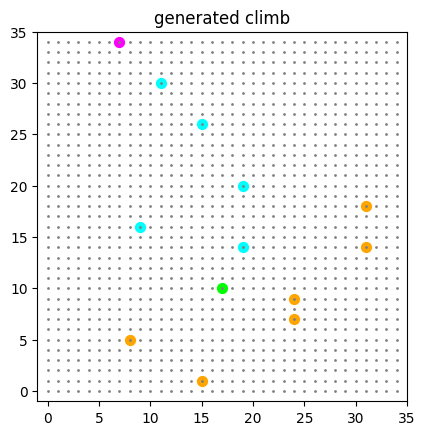

COO representation of the sparse matrix:
Row: [ 1  5  7  9 10 14 14 16 18 20 26 30 34]
Column: [15  8 24 24 17 19 31  9 31 19 15 11  7]
Data: [5 5 5 5 2 3 5 3 5 3 3 3 4]
p1137r12p1155r12p1184r13p1222r13p1256r13p1324r13p1392r14p1452r15p1527r15


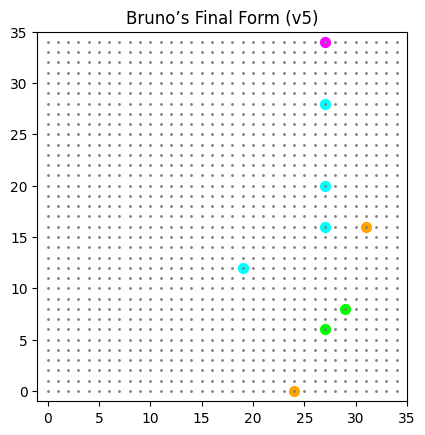

In [51]:
def print_sparse_matrix(sparse_matrix):
    print("COO representation of the sparse matrix:")
    print("Row:", sparse_matrix.row)
    print("Column:", sparse_matrix.col)
    print("Data:", sparse_matrix.data)
    
# Define a function to plot a sparse matrix with different hold types as different colors
def plot_climb(sparse_matrix, title):
    hold_colors = {2: '#00FF00', 3: '#00FFFF', 4: '#FF00FF', 5: 'orange'}

    x = sparse_matrix.col
    y = sparse_matrix.row
    z = sparse_matrix.data

    plt.xlim(-1, 35)
    plt.ylim(-1, 35)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # since its a sparse matrix, we can just plot the elements that are there
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=hold_colors[z[i]], s=50)
    
    # we are plotting the smaller grey dots after over on top of the colored ones
    for i in range(35):
        for j in range(35):
            plt.scatter(i, j, color='grey', s=1)
    plt.title(title)
    plt.show()

def plot_random_climb():
    random_sample = filtered_df.sample()
    frame = random_sample['frames'].values[0]
    print(frame)
    sparse_matrix = frame_to_sparse_matrix(frame)
    plot_climb(sparse_matrix, f"{random_sample['name'].values[0]} (v{random_sample['vgrade'].values[0]})")

def plot_generated_climb(start_hold,number_of_holds):
    generated_climb_frame = "p" + predict_valid_sequence(chain, start_hold, number_of_holds).replace(" ", "p")[0:-1]
    if generated_climb_frame[-1]=="p":
        generated_climb_frame = generated_climb_frame[0:-1]
    print(generated_climb_frame)
    sparse_matrix = frame_to_sparse_matrix(generated_climb_frame)
    plot_climb(sparse_matrix, "generated climb")
    print_sparse_matrix(sparse_matrix)

plot_generated_climb('1476r15', 13)
plot_random_climb()


### Open Pandas gui for database

In [ ]:
# show(filtered_df)

### Cost Functions

In [ ]:


# hold_direction_embeddings = 
# hold_magnitude_embeddings = 

def hold_distance(hold_1_id, hold_2_id, coo_matrix):
    #given hold id in sparse matrix representation return distance
    x1, y1 = sparse_matrix.col[hold_1_id], sparse_matrix.row[hold_1_id]
    x2, y2 = sparse_matrix.col[hold_2_id], sparse_matrix.row[hold_2_id]
    
    # Calculate Euclidean distance between the two holds
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

hold_directions = []
hold_magnitude = []

def get_hold_vector(hold_id, coo_matrix):# get hold embedding
    x = coo_matrix.row[hold_id]
    y = coo_matrix.col[hold_id]
    # data = coo_matrix.data[hold_id] # if its a foot maybe do something different?
    hold_vector = hold_directions[34-y][x] * hold_magnitude[34-y][x]
    return hold_vector

def move_cost(pos_1, pos_2, coo_matrix): # find cost of a move given two body positions
    move_cost = 
    return move_cost

def generate_positions(coo_matrix): # find all possible valid body positions on a climb
    positions = []
    return positions
def generate_cost_matrix(): #generate adjacency matrix 
    cost_matrix = 
    return cost_matrix

def find_beta_path():# use dijkstras to find easiest path in adjacency matrix
# def D_loss(coo_matrix):
#     # generate a directed weighted graph of a climb where the weights are how difficult moves are
#     # the goal is to traverse the graph with the 4 limb pointers like 4 travelling salesmen
#     # rules for traversing the graph 

def U_loss():

# def S_loss(coo_matrix):

# #iterate through startholds. If any holds are outside of desired range

# def F_loss(coo_matrix):
#     # iterate through startholds If any holds are outside of desired range

import numpy as np

# Create a 35x35 array filled with zeros
data = np.zeros((35, 35, 2))

# Save the array to an NPZ file
np.savez_compressed('data.npz', data=data)